In [136]:
from pyspark.sql import SparkSession

import matplotlib.pyplot as plt
import pandas as pd

In [137]:

spark = SparkSession.builder \
    .appName("YelpDataAnalysis") \
    .getOrCreate()

In [ ]:
yelp_df = spark.read.json("path to.../yelp_dataset/yelp_academic_dataset_business.json")
yelp_review_df = spark.read.json("path to.../yelp_dataset/yelp_academic_dataset_review.json")
yelp_checkin_df = spark.read.json("path to.../yelp_dataset/yelp_academic_dataset_checkin.json")

In [139]:
yelp_review_df.printSchema()
yelp_review_df.show(5)

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|XQfwVwDr-v0ZS3_Cb...|   0|2018-07-07 22:09:11|    0|KU_O5udG6zpxOg-Vc...|  3.0|If you decide to ...|     0|mh_-eMZ6K5RLWhZyI...|
|7ATYjTIgM3jUlt4UM...|   1|2012-01-03 15:28:18|    0|BiTunyQ73aT9WBnpR...|  5.0|I've taken a lot ...|     1|OyoGAe7OKpv6SyGZT...|
|YjUWPp

In [140]:
arizona_df = yelp_df.filter(yelp_df["state"] == "AZ")
arizona_review_df = yelp_review_df
arizona_checkin_df = yelp_checkin_df
# Show first few rows
arizona_df.show(5)

+--------------------+--------------------+--------------------+--------------------+------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|  city|               hours|is_open|  latitude|   longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|5255 E Broadway Blvd|{null, null, null...|tUFrWirKiKi_TAnsV...|Department Stores...|Tucson|{8:0-23:0, 8:0-22...|      0| 32.223236| -110.880452|              Target|      85711|          22|  3.5|   AZ|
|     625 N Stone Ave|{null, null, null...|rBmpy_Y1UbBx8ggHl...|Automotive, Auto ...|Tucson|{8:0-17:0, 0:0-0:...|      1|32.2298719|-110.9723419|Arizona Truck Out...|      85705|      

In [141]:
arizona_df.write.parquet("file:///home/dps/Documents/temp/arizona_businesses.parquet", mode="overwrite")
arizona_review_df.write.parquet("file:///home/dps/Documents/temp/arizona_businesses_review.parquet", mode="overwrite")
arizona_checkin_df.write.parquet("file:///home/dps/Documents/temp/arizona_businesses_checkin.parquet", mode="overwrite")

In [142]:
yelp_df.select("categories").distinct().show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------+
|categories                                                                                                                   |
+-----------------------------------------------------------------------------------------------------------------------------+
|Arts & Entertainment, Event Planning & Services, Venues & Event Spaces, Museums                                              |
|Food, Convenience Stores, Restaurants, Food Delivery Services, Local Flavor, Delis                                           |
|Automotive, Auto Repair, Towing, Body Shops, Oil Change Stations, Auto Parts & Supplies, Tires                               |
|Makeup Artists, Hair Salons, Beauty & Spas                                                                                   |
|Breweries, American (New), Restaurants, Burgers, American (Traditional), Gastropubs, Brewpubs, Food, Fi

In [143]:
# Filter for businesses in the 'Gyms' category
gyms_df = arizona_df.filter(arizona_df["categories"].contains("Gyms"))

# Show filtered dataset
gyms_df.show(5)

+--------------------+--------------------+--------------------+--------------------+------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|  city|               hours|is_open|  latitude|   longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|5885 W Arizona Pa...|{null, null, null...|mWv9wdM5OD7tiDzf3...|Yoga, Gyms, Sport...|Tucson|{8:0-18:0, 0:0-0:...|      1|32.3527211|-111.0908436|          LA Fitness|      85743|          76|  4.0|   AZ|
|       1400 E 6th St|{null, null, null...|gD2_HqjOwttxj0S4v...|Recreation Center...|Tucson|{6:0-0:0, 6:0-0:0...|      1| 32.227124| -110.950217|University of Ari...|      85719|      

In [144]:
gyms_df.createOrReplaceTempView("gyms")

In [145]:
# Count the number of Gyms in Arizona by city
city_result = spark.sql("""
SELECT city,COUNT(*) AS total_gyms
FROM gyms
WHERE state = "AZ"
GROUP BY city
ORDER BY total_gyms DESC
LIMIT 10""")
city_result.show()

+------------+----------+
|        city|total_gyms|
+------------+----------+
|      Tucson|        98|
|  Oro Valley|         6|
|      Marana|         2|
|Green Valley|         1|
+------------+----------+



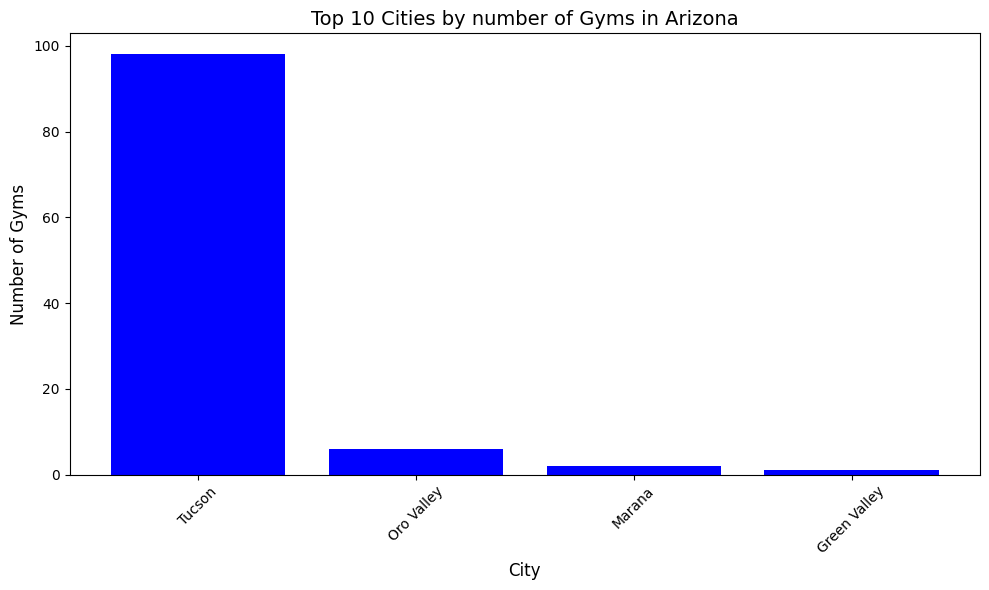

In [146]:
city_pandas_df = city_result.toPandas()

city_pandas_df = city_pandas_df.sort_values(by='total_gyms', ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.bar(city_pandas_df['city'], city_pandas_df['total_gyms'], color='blue')
plt.title('Top 10 Cities by number of Gyms in Arizona', fontsize=14)
plt.xlabel('City', fontsize=12)
plt.ylabel('Number of Gyms', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()

In [147]:
# Average star ratings of gyms by category in Arizona

category_result = spark.sql("""
SELECT categories, AVG(stars) AS avg_rating
FROM gyms
WHERE state = "AZ"
GROUP BY categories
ORDER BY avg_rating DESC
LIMIT 10""")

category_result.show()

+--------------------+----------+
|          categories|avg_rating|
+--------------------+----------+
|Massage Therapy, ...|       5.0|
|Fitness & Instruc...|       5.0|
|Active Life, Trai...|       5.0|
|Fitness & Instruc...|       5.0|
|Boot Camps, Fitne...|       5.0|
|Weight Loss Cente...|       5.0|
|Fitness & Instruc...|       5.0|
|Trainers, Gyms, A...|       5.0|
|Active Life, Fitn...|       5.0|
|Trainers, Sports ...|       5.0|
+--------------------+----------+



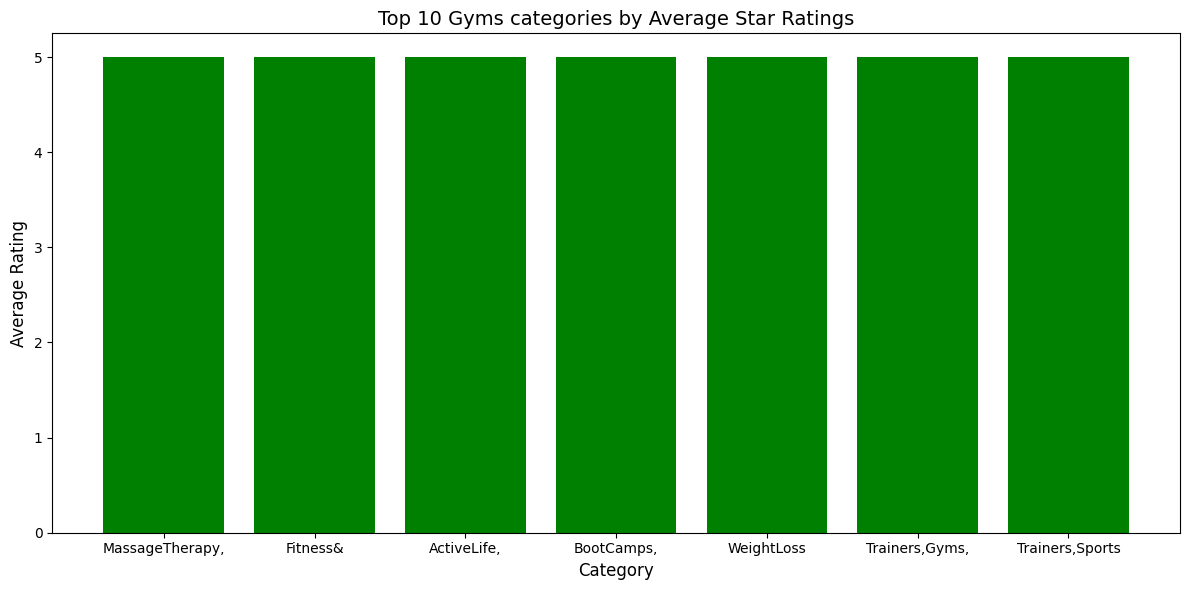

In [148]:
category_pandas_df = category_result.toPandas()

category_pandas_df['short_category'] = category_pandas_df['categories'].apply(lambda x:''.join(x.split()[:2]))

plt.figure(figsize=(12,6))
plt.bar(category_pandas_df['short_category'], category_pandas_df['avg_rating'], color='green')
plt.title('Top 10 Gyms categories by Average Star Ratings', fontsize=14)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

In [149]:
arizona_review_df.createOrReplaceTempView("review")

In [150]:
# Top-rated gyms with more than 100 reviews in Arizona

top_rated_result = spark.sql("""
SELECT g.name, g.city, g.postal_code, AVG(r.stars) AS avg_rating, COUNT(r.review_id) AS total_reviews
FROM gyms g
JOIN review r ON g.business_id = r.business_id
WHERE g.state = "AZ"
GROUP BY g.name, g.city, g.postal_code
HAVING COUNT(r.review_id) > 100
ORDER BY avg_rating DESC
LIMIT 10""")

top_rated_result.show()

+--------------------+------+-----------+------------------+-------------+
|                name|  city|postal_code|        avg_rating|total_reviews|
+--------------------+------+-----------+------------------+-------------+
|       Chuze Fitness|Tucson|      85712|3.9054054054054053|          148|
|          LA Fitness|Tucson|      85719| 3.194244604316547|          139|
|Banner Health - U...|Tucson|      85719|1.9913419913419914|          231|
+--------------------+------+-----------+------------------+-------------+



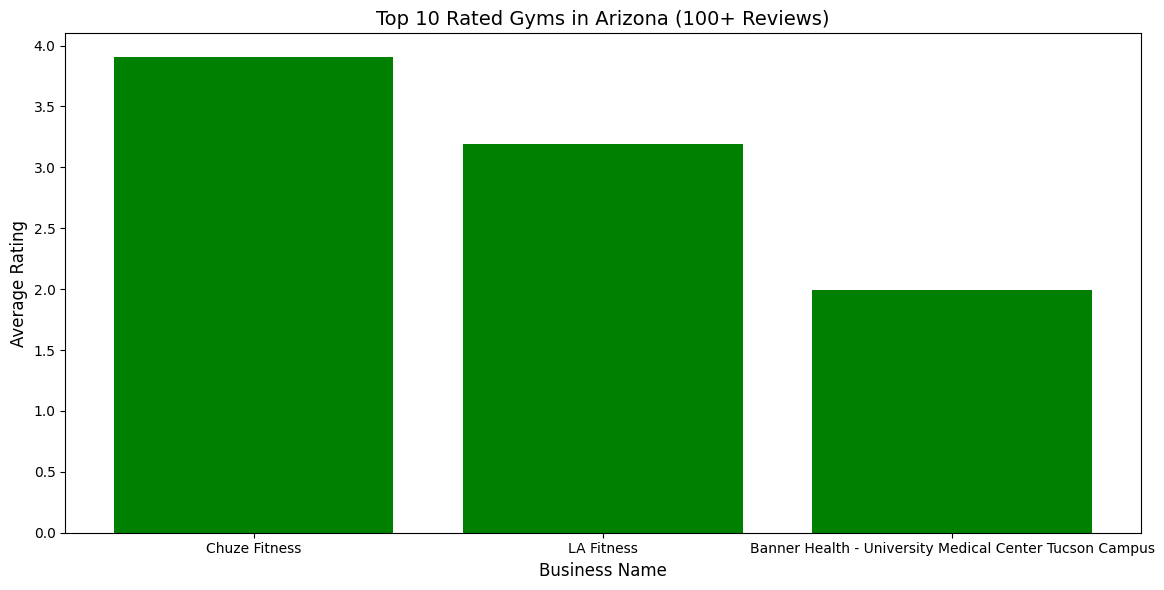

In [151]:
top_rated_pandas_df = top_rated_result.toPandas()

top_rated_pandas_df = top_rated_pandas_df.sort_values(by='avg_rating', ascending=False).head(10)

plt.figure(figsize=(12,6))
plt.bar(top_rated_pandas_df['name'], top_rated_pandas_df['avg_rating'], color='green')
plt.title('Top 10 Rated Gyms in Arizona (100+ Reviews)', fontsize=14)
plt.xlabel('Business Name', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

In [152]:
# Most popular ZIP codes for Gyms in Arizona

popular_zip_result = spark.sql("""
SELECT g.postal_code, AVG(r.stars) AS avg_rating, COUNT(r.review_id) AS total_reviews
FROM gyms g
JOIN review r ON g.business_id = r.business_id
WHERE g.state = "AZ"
GROUP BY g.postal_code
ORDER BY avg_rating DESC, total_reviews DESC
LIMIT 10""")

popular_zip_result.show()

+-----------+------------------+-------------+
|postal_code|        avg_rating|total_reviews|
+-----------+------------------+-------------+
|      85750| 4.379310344827586|           58|
|      85718| 4.342342342342342|          111|
|      85745|4.1923076923076925|           26|
|      85705| 4.189075630252101|          238|
|      85701| 4.012903225806451|          155|
|      85710| 3.973821989528796|          191|
|      85737|3.8805970149253732|           67|
|      85715|3.8421052631578947|           76|
|      85749|3.8372093023255816|           43|
|      85716|         3.8359375|          128|
+-----------+------------------+-------------+



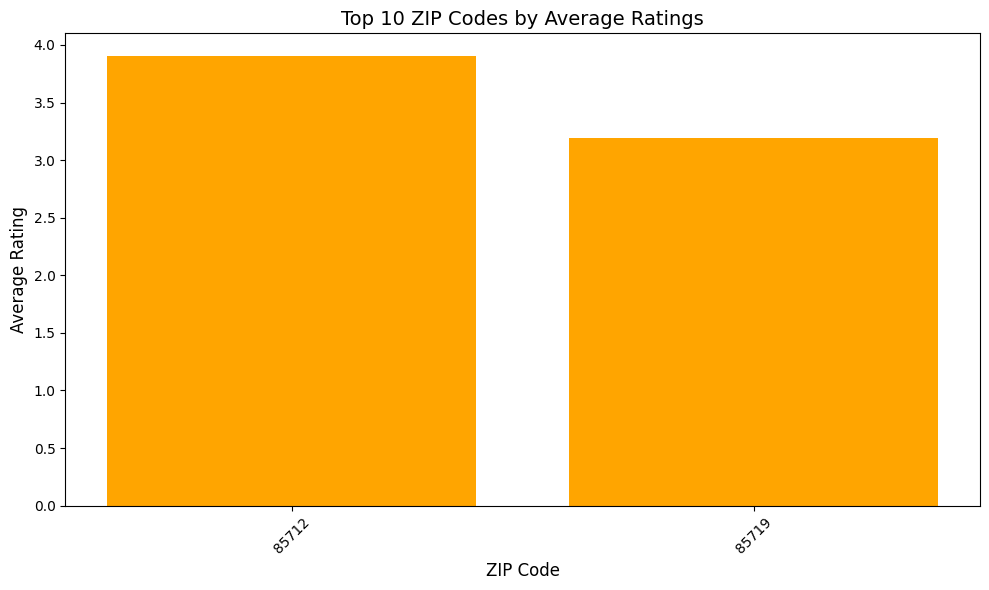

In [153]:
popular_zip_result_pandas_df = top_rated_result.toPandas()

popular_zip_result_pandas_df = popular_zip_result_pandas_df.sort_values(by='avg_rating', ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.bar(popular_zip_result_pandas_df['postal_code'], popular_zip_result_pandas_df['avg_rating'], color='orange')
plt.title('Top 10 ZIP Codes by Average Ratings', fontsize=14)
plt.xlabel('ZIP Code', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()

In [154]:
# Number of Reviews that correlate with high average ratings for Gyms

total_reviews_result = spark.sql("""
SELECT g.name,g.city,COUNT(r.review_id) AS total_reviews, AVG(r.stars) AS avg_rating
FROM gyms g
JOIN review r ON g.business_id = r.business_id
WHERE g.state = "AZ"
GROUP BY g.name, g.city
HAVING COUNT(r.review_id) > 20
ORDER BY total_reviews DESC
LIMIT 10""")

total_reviews_result.show()

+--------------------+----------+-------------+------------------+
|                name|      city|total_reviews|        avg_rating|
+--------------------+----------+-------------+------------------+
|          LA Fitness|    Tucson|          410| 3.268292682926829|
|       Chuze Fitness|    Tucson|          313|3.9041533546325877|
|Banner Health - U...|    Tucson|          231|1.9913419913419914|
|    Platinum Fitness|    Tucson|          181|2.4198895027624308|
|      Planet Fitness|    Tucson|          122| 3.262295081967213|
|    Prestige Fitness|    Tucson|           97| 4.371134020618556|
|Tucson Racquet & ...|    Tucson|           82| 3.902439024390244|
|          LA Fitness|Oro Valley|           76|3.4210526315789473|
|     Anytime Fitness|    Tucson|           65| 3.246153846153846|
|     Esporta Fitness|    Tucson|           59|3.3220338983050848|
+--------------------+----------+-------------+------------------+



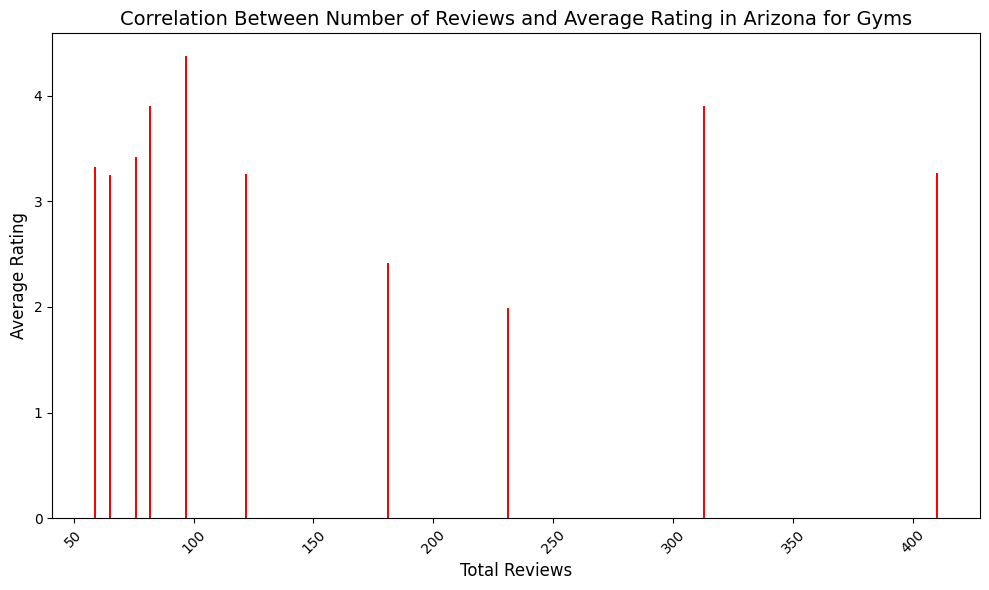

In [155]:
total_reviews_pandas_df = total_reviews_result.toPandas()

total_reviews_pandas_df = total_reviews_pandas_df.sort_values(by='avg_rating', ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.bar(total_reviews_pandas_df['total_reviews'], total_reviews_pandas_df['avg_rating'], color='red')
plt.title('Correlation Between Number of Reviews and Average Rating in Arizona for Gyms', fontsize=14)
plt.xlabel('Total Reviews', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()